In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")

/mnt/disk1/sumdev/CourseWork/a3_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets and Create Dataset Class

In [2]:
from transformers import BertModel, BertTokenizer

class EmotionDataset(Dataset):
    def __init__(self, json_file, model_name='all-MiniLM-L6-v2'):
        self.data = []
        self.speaker_encoder = LabelEncoder()
        self.model = SentenceTransformer(model_name)
        self.emotion_class_to_idx = {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'fear': 4, 'disgust': 5, 'surprise': 6}
        with open(json_file, 'r') as f:
            data = json.load(f)
            for entry in data:
                self.data.append(entry)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        speakers = torch.tensor(self.speaker_encoder.fit_transform(entry["speakers"]), dtype=torch.long)
        emotions = torch.tensor([self.emotion_class_to_idx[emotion] for emotion in entry["emotions"]], dtype=torch.long)
        utterance_embeddings = torch.tensor(self.model.encode(entry["utterances"]), dtype=torch.float)
        return torch.tensor(len(entry["speakers"])), speakers, utterance_embeddings, emotions


# Initialize the dataset and dataloader
train_dataset = EmotionDataset("../Data/train_file.json")
val_dataset = EmotionDataset("../Data/val_file.json")
print('Length of train dataset:', len(train_dataset))
print('Length of val dataset:', len(val_dataset))

Length of train dataset: 6740
Length of val dataset: 843


In [3]:
conversation_len, speakers, utterance_embeddings, emptions = train_dataset[0]
print('Conversation length:', conversation_len)
print('Speakers:', speakers)
print('Utterance embeddings:', utterance_embeddings.shape)
print('Emotions:', emptions.shape)

Conversation length: tensor(5)
Speakers: tensor([1, 0, 1, 0, 1])
Utterance embeddings: torch.Size([5, 384])
Emotions: torch.Size([5])


### Training Dataset Class Distribution


In [5]:
class_label = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
for i in range(len(train_dataset)):
    _, _, _, emotions = train_dataset[i]
    for emotion in emotions:
        class_label[emotion.item()] += 1
print('Class distribution:', class_label)

Class distribution: {0: 25554, 1: 10734, 2: 4542, 3: 6744, 4: 1880, 5: 1718, 6: 7785}


### Validation Dataset Class Distribution

In [23]:
class_label = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
for i in range(len(val_dataset)):
    _, _, _, emotions = val_dataset[i]
    for emotion in emotions:
        class_label[emotion.item()] += 1
print('Class distribution:', class_label)

Class distribution: {0: 3200, 1: 1259, 2: 558, 3: 788, 4: 265, 5: 215, 6: 1008}


## Create Dataloaders


In [4]:
import torch.nn as nn

def collate_fn(batch):
    length, speakers, utterance_embeddings, emotions = zip(*batch)
    length = torch.tensor(length, dtype=torch.long)
    speakers = nn.utils.rnn.pad_sequence(speakers, batch_first=True)
    utterance_embeddings = nn.utils.rnn.pad_sequence(utterance_embeddings, batch_first=True)        
    emotions = nn.utils.rnn.pad_sequence(emotions, batch_first=True)
    return length, speakers, utterance_embeddings, emotions


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print('Length of train_loader:', len(train_loader))
print('Length of val_loader:', len(val_loader))

Length of train_loader: 211
Length of val_loader: 27


In [21]:
for length, speakers, utterance_embeddings, emotions in train_loader:
    print(length.shape, speakers.shape, emotions.shape, utterance_embeddings.shape)
    # print("Conversation length:", length)
    # print("Speakers:", speakers)
    # print("Utterance embeddings:", utterance_embeddings)
    # print("Emotions:", emotions)
    break

torch.Size([32]) torch.Size([32, 19]) torch.Size([32, 19]) torch.Size([32, 19, 384])


## Create Emotion Recognition Classifier Model


In [5]:
import torch
import torch.nn as nn

class TransformerGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_dim):
        super(TransformerGRUClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.tranformer_encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=input_size//4)
        self.transformer_encoder = nn.TransformerEncoder(self.tranformer_encoder_layer, num_layers=2)
        self.GRU = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_dim)

    def forward(self, x):
        transform_out = self.transformer_encoder(x) + x
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        gru_out, _ = self.GRU(transform_out, h0)
        gru_out = self.fc(gru_out)
        return gru_out

## Train the Model


In [18]:
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCH = 10
INPUT_SIZE = 384
HIDDEN_SIZE = 128
OUTPUT_SIZE = 7

model = TransformerGRUClassifier(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(DEVICE)

cuda


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    model = model.to(device)
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    y_true = []
    y_pred = []
    
    for i, (_, _, utterance_embeddings, targets) in enumerate(dataloader, 1):
        utterance_embeddings = utterance_embeddings.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(utterance_embeddings)
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
        _, preds = torch.max(outputs, 2)
        running_loss += loss.item() 
        running_corrects += torch.sum(preds == targets).item()
        running_total += utterance_embeddings.size(0)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            target_expanded = targets.view(-1).cpu().numpy()
            preds_expanded = preds.view(-1).cpu().numpy()
            f1 = f1_score(target_expanded, preds_expanded, average='macro')
            accuracy = accuracy_score(target_expanded, preds_expanded)
            print(f"Batch {i}/{len(dataloader)} Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
        y_true.extend(targets.view(-1).cpu().numpy())
        y_pred.extend(preds.view(-1).cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return epoch_loss, epoch_acc, f1


def validate_model(model, dataloader, criterion, device):
    model.eval()
    model = model.to(device)
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for _, _, utterance_embeddings, targets in dataloader:
            utterance_embeddings = utterance_embeddings.to(device)
            targets = targets.to(device)
            outputs = model(utterance_embeddings)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            _, preds = torch.max(outputs, 2)
            running_loss += loss.item() 
            running_corrects += torch.sum(preds == targets).item()
            running_total += utterance_embeddings.size(0)
            y_true.extend(targets.view(-1).cpu().numpy())
            y_pred.extend(preds.view(-1).cpu().numpy())
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='macro')
    return val_loss, val_acc, val_f1



training_loss, validation_loss = [], []
training_acc, validation_acc = [], []
training_f1, validation_f1 = [], []
for epoch in range(NUM_EPOCH):
    print('-------------------------------------------------')
    print(f"Epoch {epoch+1}/{NUM_EPOCH}")
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    training_loss.append(train_loss)
    training_acc.append(train_acc)
    training_f1.append(train_f1)
    print(f"==> Train Loss: {train_loss:.4f} Accuracy: {train_acc:.4f} F1 Score: {train_f1:.4f}")
    val_loss, val_acc, val_f1 = validate_model(model, val_loader, criterion, DEVICE)
    print(f"==> Validation Loss: {val_loss:.4f} Accuracy: {val_acc:.4f} F1 Score: {val_f1:.4f}")
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    validation_f1.append(val_f1)

-------------------------------------------------
Epoch 1/10
Batch 10/211 Loss: 0.8080, Accuracy: 0.7188, F1 Score: 0.1612
Batch 20/211 Loss: 0.6384, Accuracy: 0.7859, F1 Score: 0.2291
Batch 30/211 Loss: 0.5995, Accuracy: 0.8170, F1 Score: 0.2949
Batch 40/211 Loss: 0.4458, Accuracy: 0.8531, F1 Score: 0.3503
Batch 50/211 Loss: 0.5517, Accuracy: 0.8274, F1 Score: 0.3642
Batch 60/211 Loss: 0.5212, Accuracy: 0.7946, F1 Score: 0.3538
Batch 70/211 Loss: 0.5817, Accuracy: 0.8160, F1 Score: 0.4083
Batch 80/211 Loss: 0.4630, Accuracy: 0.8409, F1 Score: 0.4134
Batch 90/211 Loss: 0.4550, Accuracy: 0.8421, F1 Score: 0.4254
Batch 100/211 Loss: 0.5262, Accuracy: 0.8162, F1 Score: 0.4174
Batch 110/211 Loss: 0.3700, Accuracy: 0.8663, F1 Score: 0.4634
Batch 120/211 Loss: 0.2993, Accuracy: 0.9105, F1 Score: 0.6358
Batch 130/211 Loss: 0.2691, Accuracy: 0.9187, F1 Score: 0.6835
Batch 140/211 Loss: 0.2737, Accuracy: 0.9210, F1 Score: 0.7121
Batch 150/211 Loss: 0.2818, Accuracy: 0.9119, F1 Score: 0.6314
Bat

In [20]:
model = model.to('cpu')
torch.save(model.state_dict(), "M2.pt")

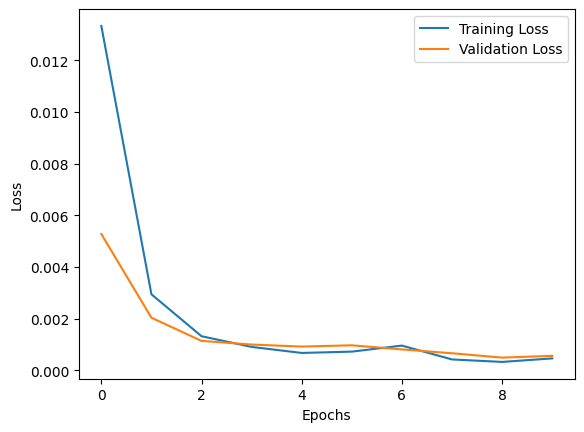

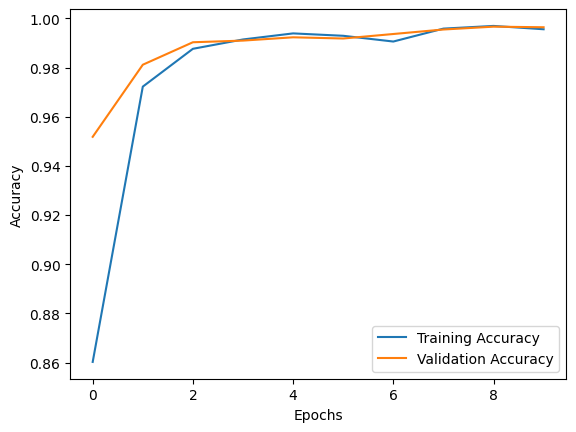

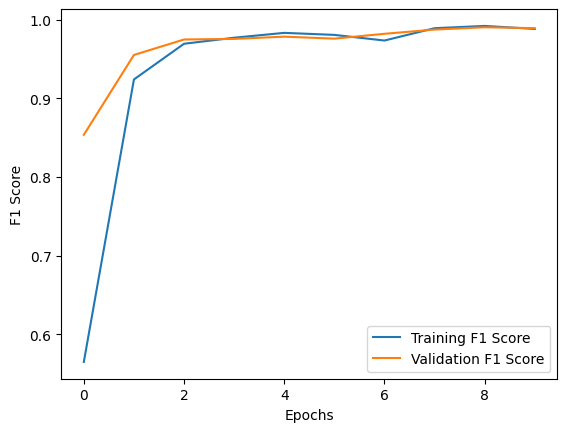

In [21]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(training_acc, label='Training Accuracy')
plt.plot(validation_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(training_f1, label='Training F1 Score')
plt.plot(validation_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

## Run Inference on Validation Dataset


In [22]:
for _, _, utterance_embeddings, emotions in val_loader:
    emotions = emotions.to(DEVICE)
    utterance_embeddings = utterance_embeddings.to(DEVICE)
    model = model.to(DEVICE)
    outputs = model(utterance_embeddings)
    loss = criterion(outputs.view(-1, outputs.size(-1)), emotions.view(-1))
    _, preds = torch.max(outputs, 2)
    target_expanded = emotions.view(-1).cpu().numpy()
    preds_expanded = preds.view(-1).cpu().numpy()
    print(len(target_expanded), len(preds_expanded))
    f1 = f1_score(target_expanded, preds_expanded, average='macro')
    accuracy = accuracy_score(target_expanded, preds_expanded)
    print(f"Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(target_expanded)
    print(preds_expanded)
    break

640 640
Loss: 0.0052, Accuracy: 0.9984, F1 Score: 0.9905
[3 0 0 6 3 5 0 0 0 3 4 6 0 2 2 6 0 0 0 0 0 1 0 0 3 6 3 4 0 0 0 4 0 0 0 0 0
 0 0 0 0 0 0 1 4 1 6 5 6 0 0 0 0 0 0 0 0 0 0 0 6 0 5 0 6 6 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 5 5 3 2 6 3 0 3 3 3 3 4 0 0 0 0 0 0 0 0 0 1 0 0 1 3 1 1 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 4 0 5 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 6 6 1 2 0 4
 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 6 2 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 3 3 0 0 3 1 2 0 0 0 0 0 1 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 1 0 0 0 1 2 6 6 1 0 0 0 0 0 0 0 0 0 1 3 0 1 1 2 6 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 5 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 6 6 0 0 0 0 0
 0 1 0 2 1 0 0 1 1 1 2 0 0 1 3 6 0 3 0 6 3 0 0 0 4 4 4 0 4 0 0 3 6 0 1 5 0
 0 0 0 0 0 0 0 0 1 6 6 0 1 6 0 1 4 1 0 0 0 0 0 0 0 0 0 6 0 1 1 0 0 0 1 1 1
 0 0 0 6 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 6 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 6 6
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 5 0 

## Predict Emotions and Detecting the Flips in Emotions in a conversation


In [6]:
with open("../Data/train_file.json", 'r') as f:
    train_json = json.load(f)
with open("../Data/val_file.json", 'r') as f:
    val_json = json.load(f)
print('Train Samples:', len(train_json))
print('Val Samples:', len(val_json))

Train Samples: 6740
Val Samples: 843


In [7]:
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score, accuracy_score

sentence_emb_model = SentenceTransformer('all-MiniLM-L6-v2')
emotion_class_to_idx = {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'fear': 4, 'disgust': 5, 'surprise': 6}
emotion_idx_to_class = {v: k for k, v in emotion_class_to_idx.items()}

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCH = 10
INPUT_SIZE = 384
HIDDEN_SIZE = 128
OUTPUT_SIZE = 7

trained_model = TransformerGRUClassifier(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(DEVICE)
trained_model.load_state_dict(torch.load("M2.pt"))

<All keys matched successfully>

In [9]:
def conversation_inference(model:TransformerGRUClassifier, conversation:dict):
    model.eval()
    utterances = conversation["utterances"]
    true_emotions = conversation["emotions"]
    speakers = conversation["speakers"]
    
    # Obtain the utterance embeddings and predict the emotions of all the utterances
    utterance_embeddings = torch.tensor(sentence_emb_model.encode(utterances), dtype=torch.float)
    utterance_embeddings = utterance_embeddings.unsqueeze(0).to(DEVICE)
    predicted_emotions = model(utterance_embeddings)
    _, predicted_emotions = torch.max(predicted_emotions, 2)
    predicted_emotions = predicted_emotions.squeeze(0)
    predicted_emotions = [emotion_idx_to_class[emotion.item()] for emotion in predicted_emotions]

    # Show the Accuracy and F1 Score of the prediction
    accuracy = accuracy_score(true_emotions, predicted_emotions)
    f1 = f1_score(true_emotions, predicted_emotions, average='macro')
    print('True emotions:', true_emotions)
    print('Predicted emotions:', predicted_emotions)
    print('Accuracy of Prediction:', accuracy)
    print('F1 Score of Prediction:', f1)
    
    # Predicting the Emotion Flips
    print('\n---------------------------------')
    print('Detecting Speaker Emotion Flips')
    print('speakers in conversation:')
    print(speakers)
    print('Predicted Emotions:')
    print(predicted_emotions)
    print()
    speakers_prev_emotion = {speaker:None for speaker in speakers}
    for i, (speaker, true_emotion, predicted_emotion) in enumerate(zip(speakers, true_emotions, predicted_emotions)):
        if speakers_prev_emotion[speaker] is None:
            speakers_prev_emotion[speaker] = predicted_emotion
        else:
            if speakers_prev_emotion[speaker] != predicted_emotion:
                print(f'{speaker} changed emotion from {speakers_prev_emotion[speaker]} to {predicted_emotion}')
                speakers_prev_emotion[speaker] = predicted_emotion
    return    

ind = 200
conversation = val_json[ind]
conversation_inference(trained_model, conversation)    

True emotions: ['anger', 'joy', 'neutral', 'joy', 'joy']
Predicted emotions: ['anger', 'joy', 'neutral', 'joy', 'anger']
Accuracy of Prediction: 0.8
F1 Score of Prediction: 0.8222222222222223

---------------------------------
Detecting Speaker Emotion Flips
speakers in conversation:
['Phoebe', 'Monica', 'Phoebe', 'Monica', 'Phoebe']
Predicted Emotions:
['anger', 'joy', 'neutral', 'joy', 'anger']

Phoebe changed emotion from anger to neutral
Phoebe changed emotion from neutral to anger


### Check Stats on Validation Dataset

In [10]:
criterion = nn.CrossEntropyLoss()
y_pred = []
y_true = []
for _, _, utterance_embeddings, emotions in val_loader:
    emotions = emotions.to(DEVICE)
    utterance_embeddings = utterance_embeddings.to(DEVICE)
    trained_model = trained_model.to(DEVICE)
    outputs = trained_model(utterance_embeddings)
    loss = criterion(outputs.view(-1, outputs.size(-1)), emotions.view(-1))
    _, preds = torch.max(outputs, 2)
    target_expanded = emotions.view(-1).cpu().numpy()
    preds_expanded = preds.view(-1).cpu().numpy()
    y_true.extend(target_expanded)
    y_pred.extend(preds_expanded)
print('Validation Accuracy:', accuracy_score(y_true, y_pred))
print('Validation F1 Score:', f1_score(y_true, y_pred, average='macro'))

Validation Accuracy: 0.9964026583744894
Validation F1 Score: 0.98930110022866
